In [12]:
import pandas as pd
import os
%matplotlib notebook
import matplotlib.pyplot as plt

# LeNet5 Train

In [22]:
path = "../runs/LeNet5/train_logs.xlsx"
df = pd.read_excel(path, index_col=0)

<IPython.core.display.Javascript object>


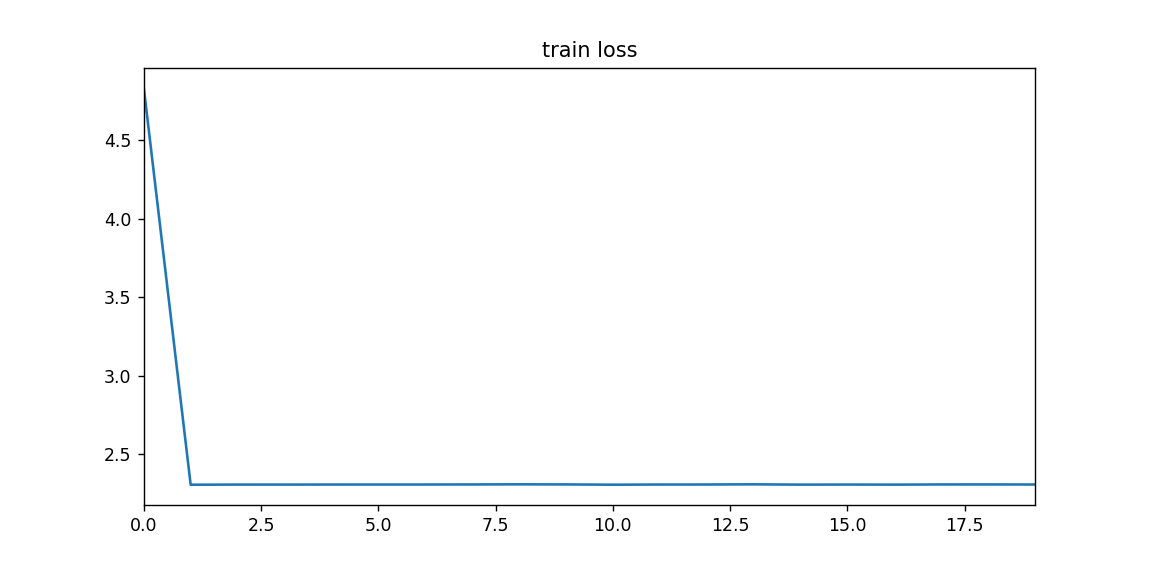

In [23]:
df['train loss'].plot(title='train loss')